In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#gpuの確認
print(torch.cuda.is_available())

True


In [2]:
#学習済みの分散表現をロードする
from torchtext.vocab import Vectors

english_fasttext_vectors = Vectors(name='drive/My Drive/wiki-news-300d-1M.vec')

print(english_fasttext_vectors.dim)
print(len(english_fasttext_vectors.itos))

100%|█████████▉| 999671/999994 [01:35<00:00, 11222.31it/s]

300
999994


In [3]:
import string
import re

# 以下の記号はスペースに置き換えます（カンマ、ピリオドを除く）。
# punctuationとは日本語で句点という意味です
print("区切り文字：", string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# 前処理
def preprocessing_text(text):
    # 改行コードを消去
    text = re.sub('<br />', '', text)

    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ","):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）
def tokenizer_punctuation(text):
    return text.strip().split()


# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret


# 動作を確認します
print(tokenizer_with_preprocessing('I like cats+'))

区切り文字： !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['I', 'like', 'cats']


In [4]:
import torchtext
from torchtext.data.utils import get_tokenizer

#テキストに処理を行うFieldを定義
#fix_lengthはtokenの数
TEXT = torchtext.data.Field(sequential=True, use_vocab=True, tokenize=tokenizer_with_preprocessing,
                            lower=True, include_lengths=True, batch_first=True, fix_length=40)

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

#pandasでcsvを保存するときに、labelをintでキャストしておかないとエラーでるから注意
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(
    path='drive/My Drive/dataset/CBET/ekman', train='train.csv', validation='val.csv', 
    test='test.csv', format='csv', fields=[('Text', TEXT), ('Label', LABEL)])

In [88]:
#ボキャブラリを作成する
TEXT.build_vocab(train_ds, vectors=english_fasttext_vectors)

print(len(TEXT.vocab.stoi))

batch_size = 64
d_model = 300
num_filters = [100, 100, 100]
filter_sizes = [3, 4, 5]
num_unit = 100
output_dim = 5
dropout_rate = 0.5

51709


In [89]:
#データローダを作成
train_dl = torchtext.data.Iterator(train_ds, batch_size=batch_size, train=True)
val_dl = torchtext.data.Iterator(val_ds, batch_size=batch_size, train=False, sort=False)
test_dl = torchtext.data.Iterator(test_ds, batch_size=batch_size, train=False, sort=False)

#テスト
batch = next(iter(val_dl))
print(len(batch.Text[0][0]))
print(batch.Label)

40
tensor([4, 0, 2, 0, 2, 4, 4, 3, 1, 4, 2, 2, 1, 2, 2, 2, 1, 2, 3, 3, 0, 3, 4, 1,
        1, 3, 0, 2, 4, 1, 2, 2, 2, 3, 1, 2, 4, 3, 3, 4, 0, 0, 1, 3, 0, 3, 4, 0,
        0, 1, 2, 2, 1, 1, 4, 3, 2, 3, 3, 3, 2, 4, 4, 2])


In [90]:
#分散表現の更新をしない
class Embedder_static(nn.Module):
  def __init__(self, text_embedding_vectors, dropout_rate):
    super().__init__()
    #tokenの数と、分散表現の次元数
    self.embeddings = nn.Embedding.from_pretrained(
        embeddings=text_embedding_vectors, freeze=True)
    self.dropout = nn.Dropout(dropout_rate)
  
  def forward(self, x):
    x = self.embeddings(x).permute(0, 2, 1) #[batch, d_model, length]
    x = self.dropout(x)
    return x

#分散表現を更新する
class Embedder_nonstatic(nn.Module):
  def __init__(self, text_embedding_vectors, dropout_rate):
    super().__init__()
    #tokenの数と、分散表現の次元数
    self.embeddings = nn.Embedding.from_pretrained(
        embeddings=text_embedding_vectors, freeze=False)
    self.dropout = nn.Dropout(dropout_rate)
  
  def forward(self, x):
    x = self.embeddings(x).permute(0, 2, 1) #[batch, d_model, length]
    x = self.dropout(x)
    return x


class CNN_Kim_Layer(nn.Module):
  def __init__(self, d_model, num_filters, filter_sizes, dropout_rate):
    super().__init__()
    self.convs = nn.ModuleList([nn.Conv1d(d_model, nf, fs) for nf, fs in zip(num_filters, filter_sizes)])
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
    x = [F.relu(conv(x).permute(0, 2, 1).max(1)[0]) for conv in self.convs] #[3, batch, filter_size]
    return x

  
class ClassificationHead(nn.Module):
  def __init__(self, num_unit, output_dim, dropout_rate):
    super().__init__()
    self.linear = nn.Linear(num_unit*6, output_dim)
    self.dropout = nn.Dropout(dropout_rate)
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, x1, x2):
    # torch.cat(x, 1).shape -> [batch, sum(filter_sizes)]
    x1.extend(x2)
    x = self.linear(torch.cat(x1, 1)) # [batch, output_dim]
    output = self.dropout(x)
    return output


class CNN_Classification(nn.Module):
  def __init__(self, text_embedding_vectors, d_model, num_filters, filter_sizes, num_unit, droutput_dim, dropout_rate):
    super().__init__()
    self.net1_1 = Embedder_static(text_embedding_vectors, dropout_rate)
    self.net1_2 = Embedder_nonstatic(text_embedding_vectors, dropout_rate)
    self.net2 = CNN_Kim_Layer(d_model, num_filters, filter_sizes, dropout_rate)
    self.net3 = ClassificationHead(num_unit, output_dim, dropout_rate)

  def forward(self, x):
    x1_1 = self.net1_1(x) # [batch_size, ntoken, d_model]
    x1_2 = self.net1_2(x)
    x2_1 = self.net2(x1_1)
    x2_2 = self.net2(x1_2) 
    out = self.net3(x2_1, x2_2) 
    return out

In [91]:
#テスト
batch = next(iter(train_dl))
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

# モデル構築
net = CNN_Classification(TEXT.vocab.vectors, d_model, num_filters, filter_sizes, 
                         num_unit, output_dim, dropout_rate) 

# 入出力
x = batch.Text[0]
x1 = net(x)

print("入力のテンソルサイズ：", x.shape)
print("出力のテンソルサイズ：", x1.shape)

入力のテンソルサイズ： torch.Size([64, 40])
出力のテンソルサイズ： torch.Size([64, 5])


In [92]:
dataloaders_dict = {'train': train_dl, 'val': val_dl}
criterion = nn.CrossEntropyLoss() 
CNN_Classification(TEXT.vocab.vectors, d_model, num_filters, filter_sizes, 
                         num_unit, output_dim, dropout_rate)
net.train()

learning_rate = 2e-4
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)

In [93]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net.to(device)

  torch.backends.cudnn.benchmark = True

  #各epoch
  for epoch in range(num_epochs):
    #訓練と評価
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()
      
      epoch_loss = 0.0 #各epochの損失の和
      epoch_corrects = 0 #各epochの正解数

      for batch in (dataloaders_dict[phase]):
        inputs = batch.Text[0].to(device)
        labels = batch.Label.to(device)

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase=='train'):
          #hidden = net.init_hidden(device) #LSTM隠れ状態の初期化
          outputs = net(inputs) #[batch_size, output_dim]

          loss = criterion(outputs, labels) #softmaxは中に入ってる
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward() #勾配を計算
            optimizer.step() #パラメータを更新

          epoch_loss += loss.item()*inputs.size(0) #バッチ数をかけてあとでデータ量で割る
          epoch_corrects += torch.sum(preds == labels.data)
      
      #各epochのloss、正解数をだす
      epoch_loss = epoch_loss/len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)
      print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,
                                                                     num_epochs, phase, epoch_loss, epoch_acc))
  return net

In [94]:
num_epochs = 10
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)
print({'次元数': d_model, 'num_filter':num_filters , 'filter_sizes': filter_sizes, 'クラス数': output_dim, 'ドロップアウト': dropout_rate, '学習率': learning_rate })

Epoch 1/10 | train |  Loss: 1.4089 Acc: 0.3664
Epoch 1/10 |  val  |  Loss: 1.1770 Acc: 0.5694
Epoch 2/10 | train |  Loss: 1.2543 Acc: 0.4357
Epoch 2/10 |  val  |  Loss: 1.0549 Acc: 0.6295
Epoch 3/10 | train |  Loss: 1.1971 Acc: 0.4612
Epoch 3/10 |  val  |  Loss: 0.9940 Acc: 0.6450
Epoch 4/10 | train |  Loss: 1.1542 Acc: 0.4797
Epoch 4/10 |  val  |  Loss: 0.9571 Acc: 0.6489
Epoch 5/10 | train |  Loss: 1.1249 Acc: 0.4919
Epoch 5/10 |  val  |  Loss: 0.9313 Acc: 0.6669
Epoch 6/10 | train |  Loss: 1.0967 Acc: 0.5030
Epoch 6/10 |  val  |  Loss: 0.9153 Acc: 0.6742
Epoch 7/10 | train |  Loss: 1.0700 Acc: 0.5156
Epoch 7/10 |  val  |  Loss: 0.9032 Acc: 0.6759
Epoch 8/10 | train |  Loss: 1.0445 Acc: 0.5255
Epoch 8/10 |  val  |  Loss: 0.9078 Acc: 0.6640
Epoch 9/10 | train |  Loss: 1.0216 Acc: 0.5320
Epoch 9/10 |  val  |  Loss: 0.8751 Acc: 0.6800
Epoch 10/10 | train |  Loss: 0.9955 Acc: 0.5462
Epoch 10/10 |  val  |  Loss: 0.8721 Acc: 0.6832
{'次元数': 300, 'num_filter': [100, 100, 100], 'filter_sizes'

In [95]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()
net_trained.to(device)

y_true = np.array([])
y_pred = np.array([])

epoch_corrects = 0

for batch in (test_dl):
  inputs = batch.Text[0].to(device)
  labels = batch.Label.to(device)

  with torch.set_grad_enabled(False):
    outputs = net_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    y_true = np.concatenate([y_true, labels.to("cpu", torch.double).numpy()])
    y_pred = np.concatenate([y_pred, preds.to("cpu", torch.double).numpy()])

    epoch_corrects += torch.sum(preds == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dl.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dl.dataset),epoch_acc))

テストデータ4569個での正解率：0.6857


In [96]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.55      0.59       870
         1.0       0.77      0.78      0.77       900
         2.0       0.76      0.84      0.80      1063
         3.0       0.61      0.47      0.53       880
         4.0       0.61      0.76      0.67       856

    accuracy                           0.69      4569
   macro avg       0.68      0.68      0.67      4569
weighted avg       0.68      0.69      0.68      4569



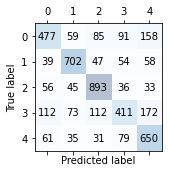

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()